<a href="https://colab.research.google.com/github/changhoonhahn/provabgs/blob/main/nb/nmfburst_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# decorder for `nmfburst` SPS model
Instead of using the PCA encoding a training a neural net to predict PCA coefficients, I'm going to try to train a decoder directly from the (theta, SED) data set. 

notebook has code lifted from: 
- https://github.com/stephenportillo/SDSS-VAE/blob/master/trainVAE.py
- https://github.com/stephenportillo/SDSS-VAE/blob/master/InfoVAE.py

In [1]:
!pip install corner

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/provabgs

/content/drive/My Drive/provabgs


In [4]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

In [5]:
import corner as DFM
import matplotlib.pyplot as plt

In [6]:
seed = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [7]:
# read in untransformed SPS parameters excluding stellar mass
_theta = np.load("train.set0.thetas_unt.npy")
logm = _theta[:,0]
theta = _theta[:,1:]

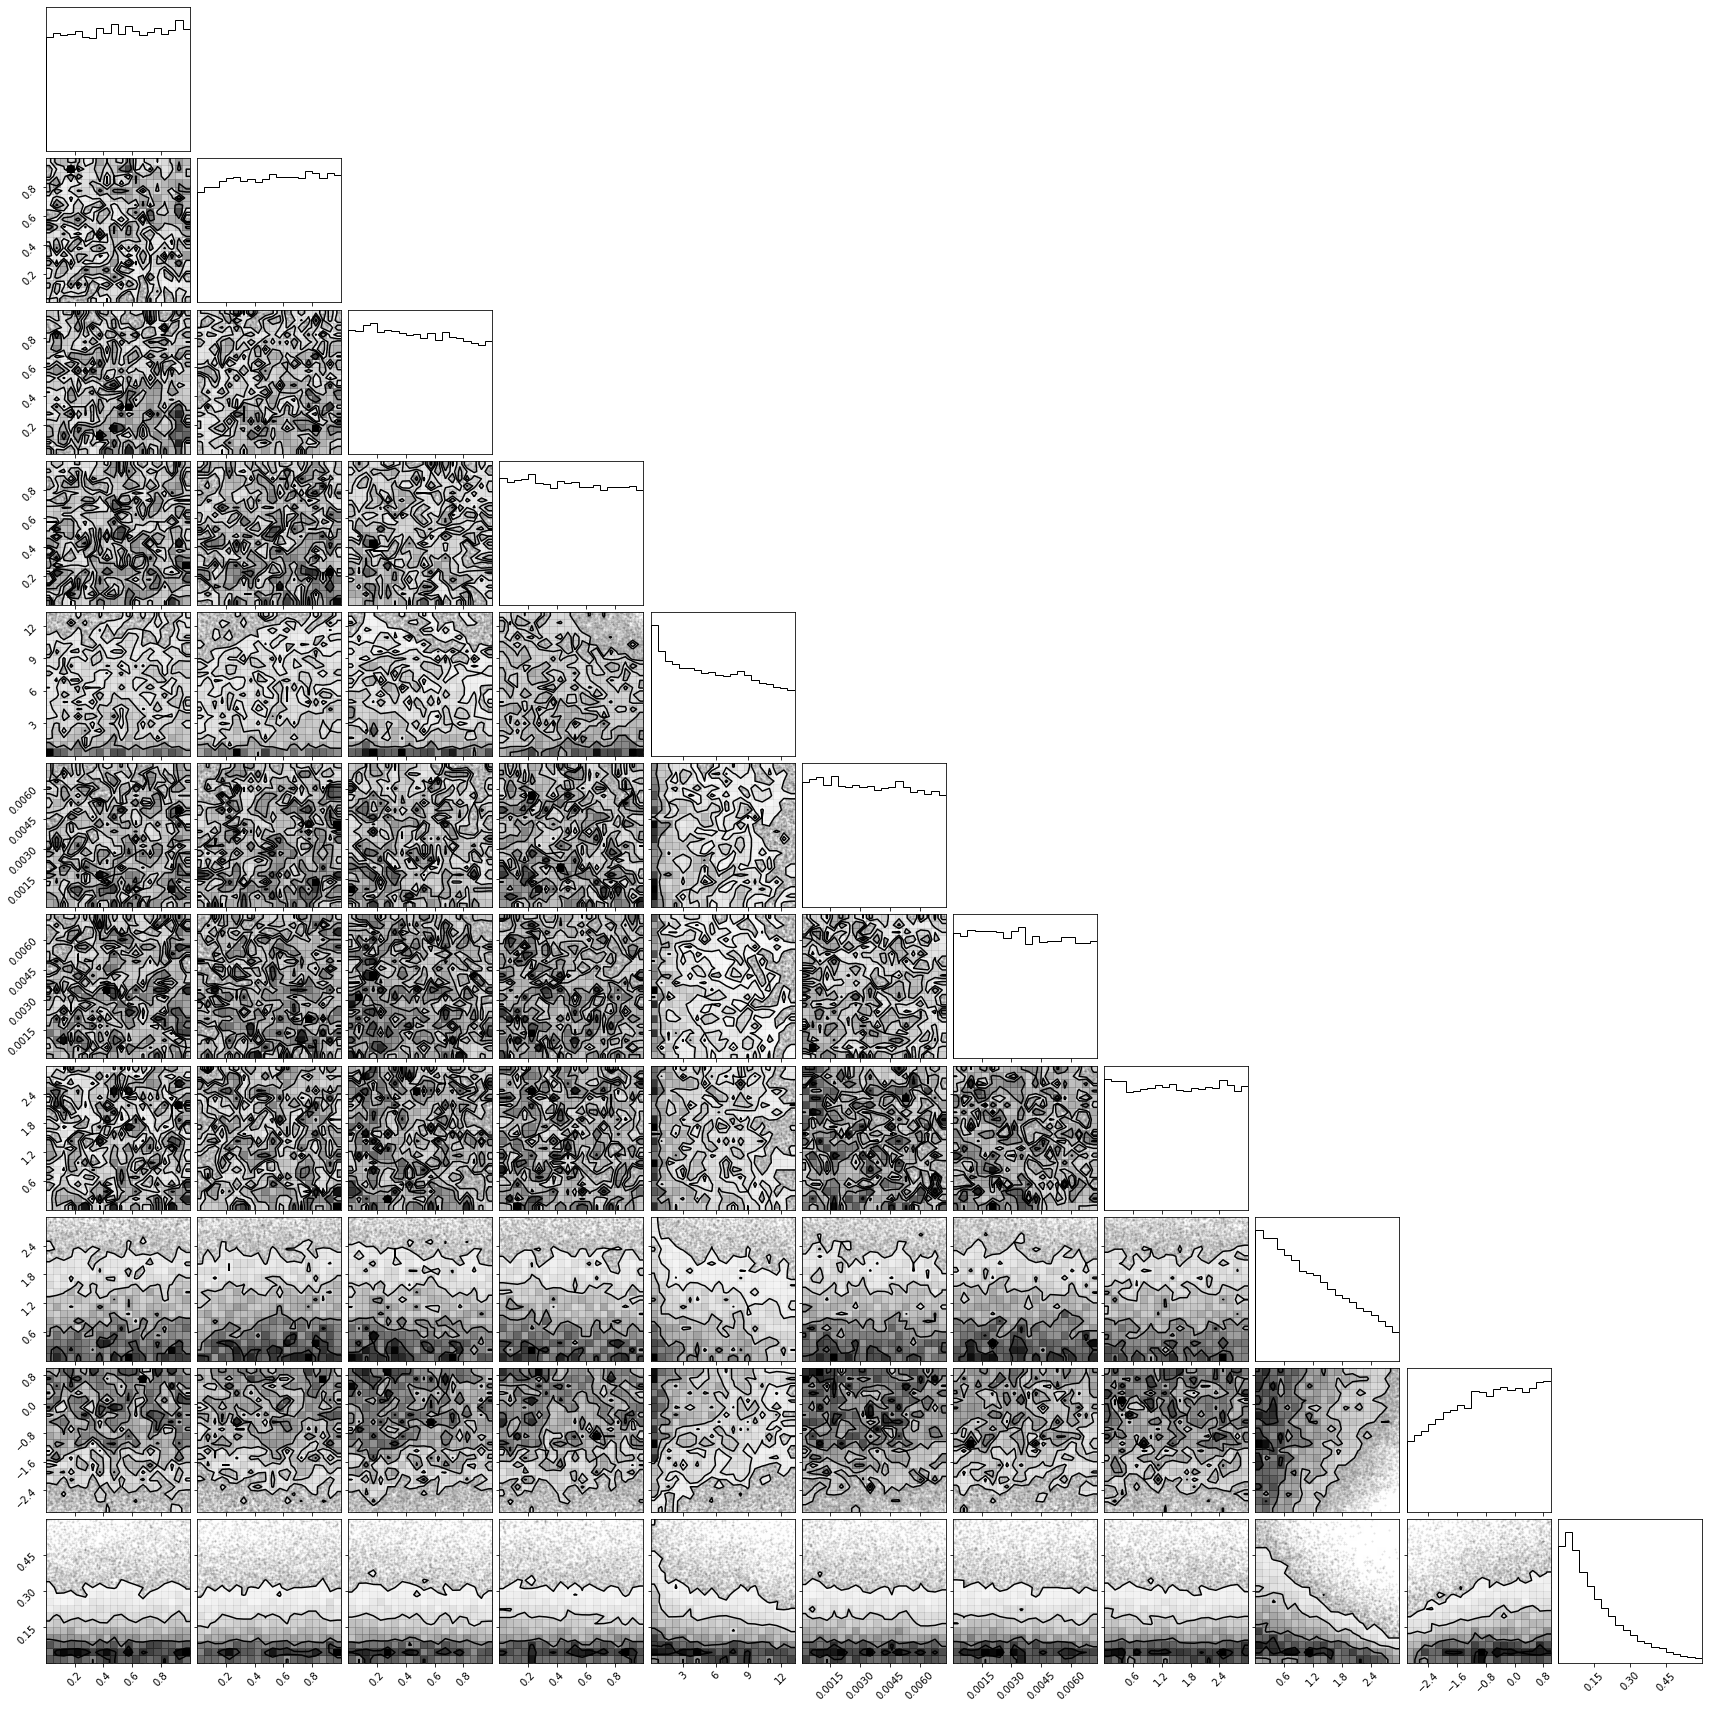

In [8]:
_ = DFM.corner(theta)

In [9]:
wave = np.load('train.set0.miles_mist.lssp.waves.npy')[0,:]

In [12]:
# read in log(SSP luminosity)
lnspec = np.log(np.load('train.set0.miles_mist.lssp.lssps.npy')/(10**logm[:,None]))

Text(0, 0.5, 'log(spectra)')

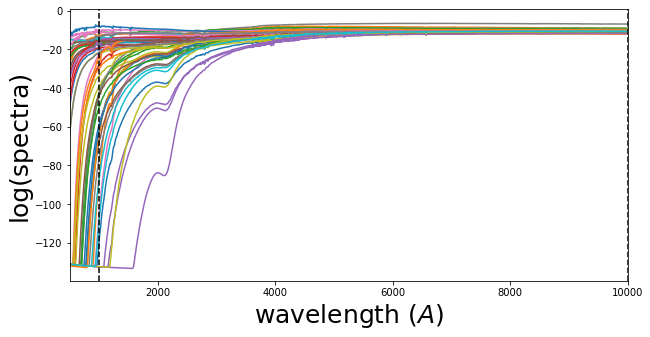

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in np.random.choice(np.arange(theta.shape[0]), size=50): 
  sub.plot(wave, lnspec[i])
sub.axvline(1e3, color='k', linestyle='--')
sub.axvline(1e4, color='k', linestyle='--')
sub.set_xlabel('wavelength ($A$)', fontsize=25)
sub.set_xlim(500, 1e4)
sub.set_ylabel('log(spectra)', fontsize=25)

In [14]:
# whiten
mu_lnspec = np.mean(lnspec, axis=0)
std_lnspec = np.std(lnspec, axis=0)
lnspec -= mu_lnspec
lnspec /= std_lnspec

(-3.0, 4.0)

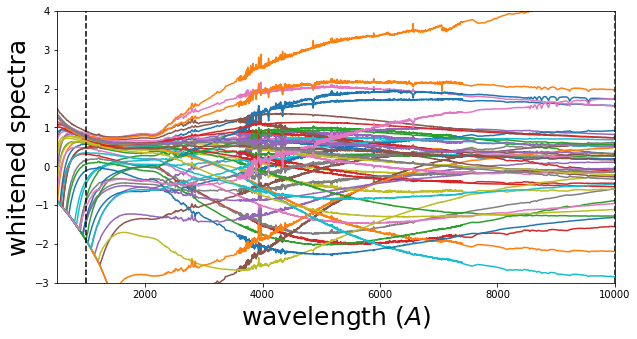

In [15]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in np.random.choice(np.arange(theta.shape[0]), size=50): 
  sub.plot(wave, lnspec[i])
sub.axvline(1e3, color='k', linestyle='--')
sub.axvline(1e4, color='k', linestyle='--')
sub.set_xlabel('wavelength ($A$)', fontsize=25)
sub.set_xlim(500, 1e4)
sub.set_ylabel('whitened spectra', fontsize=25)
sub.set_ylim(-3, 4)

In [16]:
# impose wavelength limit to fully include the FUV and wise W2 bandpasses 
wlim = (wave > 1e3) & (wave < 1e4)
lnspec = lnspec[:,wlim]

In [17]:
n_theta = theta.shape[1]
n_lnspec = lnspec.shape[1]
print('n theta = %i' % n_theta)
print('n ln(spec) = %i' % n_lnspec)

n theta = 11
n ln(spec) = 4582


In [18]:
Ntrain = int(float(theta.shape[0]) * 0.9)
Ntest = theta.shape[0] - Ntrain
print('Ntrain = %i' % Ntrain)
print('Ntest = %i' % Ntest)

Ntrain = 26238
Ntest = 2916


In [19]:
batch_size=64
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(theta[:Ntrain], dtype=torch.float32), torch.tensor(lnspec[:Ntrain], dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(theta[Ntrain:], dtype=torch.float32), torch.tensor(lnspec[Ntrain:], dtype=torch.float32)),
    batch_size=Ntest,
)

In [20]:
class Decoder(nn.Module): 
    def __init__(self, nfeat=1000, ncode=5, nhidden=[15, 30, 100], dropout=0.2):
        super(Decoder, self).__init__()
        
        self.ncode = int(ncode)
        print(nhidden)
        self.dec0 = nn.Linear(ncode, nhidden[0])
        self.dec1 = nn.Linear(nhidden[0], nhidden[1])
        self.dec2 = nn.Linear(nhidden[1], nhidden[2])
        self.outp = nn.Linear(nhidden[2], nfeat)

        self.d0 = nn.Dropout(p=dropout)
        self.d1 = nn.Dropout(p=dropout)
        self.d2 = nn.Dropout(p=dropout)
        
    def decode(self, x):
        x = self.d0(F.leaky_relu(self.dec0(x)))
        x = self.d1(F.leaky_relu(self.dec1(x)))
        x = self.d2(F.leaky_relu(self.dec2(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        return self.decode(x)
    
    def loss(self, x, y):
        recon_y = self.forward(x)
        MSE = torch.sum(0.5 * (y - recon_y).pow(2))
        return MSE

In [21]:
def train(): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        tt, lns = data
        tt = tt.to(device)
        lns = lns.to(device)

        optimizer.zero_grad()
        
        loss = model.loss(tt, lns)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader.dataset)

    with torch.no_grad(): 
        model.eval()
        valid_loss = 0.
        for data in valid_loader: 
            tt = data[0]
            tt = tt.to(device)
            lns = data[1].float()
            lns = lns.to(device)

            loss = model.loss(tt, lns) 
            valid_loss += loss
        valid_loss /= len(valid_loader.dataset)

    return valid_loss, train_loss 

class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

In [28]:
epochs = int(1e3)
n_config = 10

models, valid_losses, train_losses = [], [], [] 
for config in range(n_config):
    dropout = 0. #0.9*np.random.uniform()
    dfac = 1./(1.-dropout)

    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(100), np.log(dfac*n_lnspec)))))
    nhidden1 = int(np.ceil(np.exp(np.random.uniform(np.log(50), np.log(nhidden2)))))
    nhidden0 = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*n_theta+1), np.log(nhidden1)))))
    print('config %i, dropout = %0.2f; 3 hidden layers with %i,%i,%i nodes' % (config, dropout, nhidden0, nhidden1, nhidden2))
    
    model = Decoder(nfeat=n_lnspec, nhidden=[nhidden0, nhidden1, nhidden2], ncode=n_theta, dropout=dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=20)
    stopper = EarlyStopper(patience=10)

    for epoch in range(epochs + 1):
        valid_loss, train_loss = train()
        if epoch % 20 == 0:
          print('====> Epoch: {} TRAINING Loss: {:.2e} VALID Loss: {:.2e}'.format(epoch, train_loss, valid_loss))

        scheduler.step(train_loss)
        if (not stopper.step(train_loss)) or (epoch == epochs):
            print('Stopping')
            print('====> Epoch: {} TRAINING Loss: {:.2e} VALID Loss: {:.2e}'.format(epoch, train_loss, valid_loss))

            # save model initialization
            model_init = {}
            model_init['nfeat'] = n_lnspec
            model_init['ncode'] = n_theta
            model_init['dropout'] = dropout
            model_init['nhiddens'] = [nhidden0, nhidden1, nhidden2]
            torch.save(model_init, 'lssp.nmfburst.decoder.init.%i.pth' % config)
            torch.save(model, 'lssp.nmfburst.decoder.%i.pth' % config)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            models.append(model)
            break 

config 0, dropout = 0.00; 3 hidden layers with 212,346,1563 nodes
[212, 346, 1563]
====> Epoch: 0 TRAINING Loss: 2.42e+02 VALID Loss: 1.31e+02
====> Epoch: 20 TRAINING Loss: 4.36e+01 VALID Loss: 4.14e+01
====> Epoch: 40 TRAINING Loss: 2.95e+01 VALID Loss: 2.72e+01
====> Epoch: 60 TRAINING Loss: 2.14e+01 VALID Loss: 2.61e+01
Stopping
====> Epoch: 79 TRAINING Loss: 1.62e+01 VALID Loss: 2.81e+01
config 1, dropout = 0.00; 3 hidden layers with 16,77,3891 nodes
[16, 77, 3891]
====> Epoch: 0 TRAINING Loss: 2.91e+02 VALID Loss: 1.36e+02
====> Epoch: 20 TRAINING Loss: 4.79e+01 VALID Loss: 4.15e+01
====> Epoch: 40 TRAINING Loss: 3.19e+01 VALID Loss: 4.22e+01
Stopping
====> Epoch: 52 TRAINING Loss: 2.94e+01 VALID Loss: 2.88e+01
config 2, dropout = 0.00; 3 hidden layers with 25,294,355 nodes
[25, 294, 355]
====> Epoch: 0 TRAINING Loss: 3.16e+02 VALID Loss: 1.75e+02
====> Epoch: 20 TRAINING Loss: 4.52e+01 VALID Loss: 4.31e+01
====> Epoch: 40 TRAINING Loss: 2.87e+01 VALID Loss: 9.87e+01
====> Epoch:

# validate trained model

In [29]:
best_model = models[np.argmin(train_losses)]

In [30]:
with torch.no_grad(): 
  best_model.eval()
  wlnspec_recon = best_model.forward(torch.tensor(theta[Ntrain:], dtype=torch.float32).to(device))

lnspec_recon = std_lnspec[wlim] * wlnspec_recon.cpu().detach().numpy() + mu_lnspec[wlim]

lnspec_test = std_lnspec[wlim] * lnspec[Ntrain:] + mu_lnspec[wlim]

(1000.0, 10000.0)

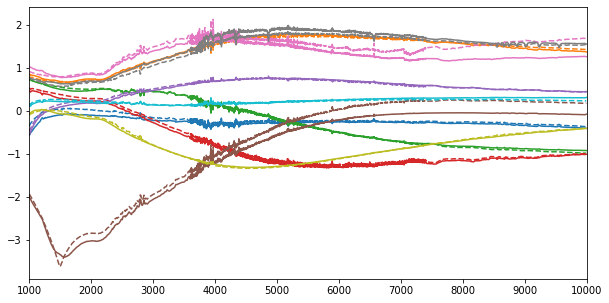

In [31]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii, i in enumerate(np.random.choice(Ntest, size=10, replace=False)): 
  sub.plot(wave[wlim], wlnspec_recon[i].cpu().detach().numpy(), c='C%i' % ii)
  sub.plot(wave[wlim], lnspec[Ntrain+i], c='C%i' % ii, ls='--')
sub.set_xlim(1e3, 1e4)#wave[wlim].min(), wave[wlim].max())

(1000.0, 10000.0)

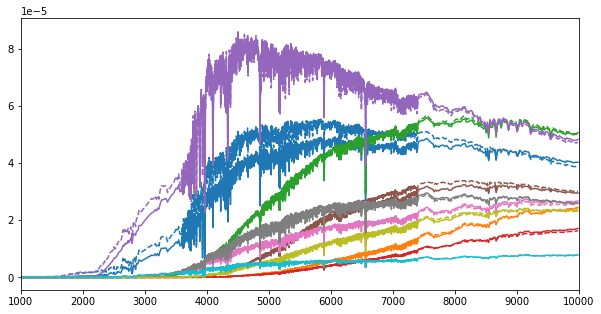

In [32]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii, i in enumerate(np.random.choice(Ntest, size=10, replace=False)): 
  sub.plot(wave[wlim], np.exp(lnspec_recon[i]), c='C%i' % ii)
  sub.plot(wave[wlim], np.exp(lnspec_test[i]), c='C%i' % ii, ls='--')
sub.set_xlim(1e3, 1e4)#wave[wlim].min(), wave[wlim].max())

(-0.1, 0.1)

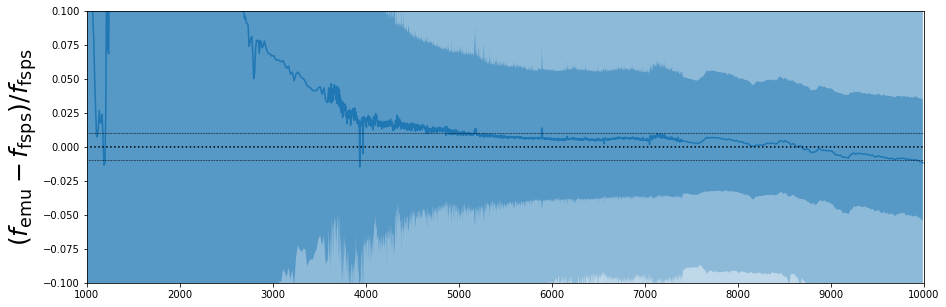

In [33]:
frac_dspectrum = 1. - np.exp(lnspec_recon - lnspec_test)
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
                                          [0.0005, 0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995, 0.9995], axis=0)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.fill_between(wave[wlim], frac_dspectrum_quantiles[0],
        frac_dspectrum_quantiles[-1], fc='C0', ec='none', alpha=0.1, label='99.9%')
sub.fill_between(wave[wlim], frac_dspectrum_quantiles[1],
        frac_dspectrum_quantiles[-2], fc='C0', ec='none', alpha=0.2, label='99%')
sub.fill_between(wave[wlim], frac_dspectrum_quantiles[2],
        frac_dspectrum_quantiles[-3], fc='C0', ec='none', alpha=0.3, label='95%')
sub.fill_between(wave[wlim], frac_dspectrum_quantiles[3],
        frac_dspectrum_quantiles[-4], fc='C0', ec='none', alpha=0.5, label='68%')
sub.plot(wave[wlim], frac_dspectrum_quantiles[4], c='C0', ls='-') 
sub.plot(wave, np.zeros(len(wave)), c='k', ls=':') 

# mark +/- 1%
sub.plot(wave, 0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)
sub.plot(wave, -0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)

sub.set_xlim(1e3, 1e4)
sub.set_ylabel(r'$(f_{\rm emu} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
sub.set_ylim(-0.1, 0.1)